In [1]:
import json
import os
import itertools

import rootpath
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
import pycountry as pc

from lhledge import cfgLoader
from lhledge import lhlFilters
from lhledge import superrouters
from lhledge import loadGeographicData

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
# CYCLE = 10020
CYCLE = 10019
DATE = 20220501


# CYCLE = 8820
# DATE = 20201002
# CYCLE = 4578
# DATE = 20160302
DOWNSAMPLING = 1
LHL_THRESHOLD = 57

In [4]:
def ecdf(data, w=[]):
    """ Compute ECDF """
    if len(w) == 0:
        w = np.ones(len(data))
    #
    #     x = np.sort(data)
    idx = np.argsort(data).values
    #
    x = np.array(data)
    x = x[idx]
    w = w[idx]
    #
    n = x.size
    #     y = np.arange(1, n + 1) / n
    y = np.cumsum(w) / sum(w)
    return (np.squeeze(x), y)

In [5]:
def ecdf2(df, field, field_aux):
    df = df.sort_values(field)
    y = np.cumsum(df.groupby(field)["router_id"].count().values)
    y = y / max(y)
    x = df.drop_duplicates(field)[field].values
    return x, y

In [6]:
def geneate_input_filename():

    filename = cfg["paths"]["ark"]["consolidated-long-haul-explorations"].format(DATE, CYCLE, DOWNSAMPLING)

    # filenames._create_dir(filename)
    return filename

In [7]:
def alpha3_to_alpha2(cc3):
    try:
        country = pc.countries.get(alpha_3=cc3)
        return country.alpha_2
    except:
        return "??"


In [8]:
# Change directory to run from the root dir of the project
path = rootpath.detect(pattern=".git")
os.chdir(path)

# load config file
cfg = cfgLoader.cfgLoader("config.yml")

# Load data

## Geographic data

In [9]:
cepii = loadGeographicData.load_inter_country_distances(
                                     "data/external/cepii/dist_cepii.csv", 
                                     "data/processed/min-cc-dist/min_cc_dist.csv")
cepii.head()

,cc_src,cc_dst,dist
0,AW,AW,5.225315
1,AW,AF,13257.810000
2,AW,AO,9516.913000
3,AW,AI,983.268200
4,AW,AL,9091.742000


## LHLs

In [10]:
lhl = pd.read_csv(geneate_input_filename(), compression="bz2")
lhl["mpls_tunnel"] = lhl["mpls_tunnel"].values.astype(bool)
lhl.head()

,near_side_addr,far_side_addr,mpls_tunnel,near_side_rdns,far_side_rdns,near_side_rtt,far_side_rtt,near_side_timestamp,far_side_timestamp,near_node_id,far_node_id,near_node_asn,far_node_asn,near_side_cc,far_side_cc,near_side_lat,near_side_lon,far_side_lat,far_side_lon,diff_rtt
0,1.1.10.5,220.177.251.10,False,1.1.10.5,10.251.177.220.broad.nc.jx.dynamic.163data.com.cn,167.529,245.570,1.651394e+09,1.651394e+09,1336104,26620343,4134,4134,CN,CN,34.77320,113.72200,39.91691,116.39706,78.041
1,1.120.111.254,1.157.139.55,False,cpe-1-120-111-254.nb13.nsw.asp.telstra.net,cpe-1-157-139-55.nb13.nsw.asp.telstra.net,34.812,43.901,1.651404e+09,1.651404e+09,3865246,0,1221,0,AU,??,-33.86010,151.21010,0.00000,0.00000,9.089
2,1.120.15.254,58.171.171.124,False,gw.vb11.vic.asp.telstra.net,58.171.171.124,167.812,179.487,1.651383e+09,1.651383e+09,1185539,24979552,1221,1221,GW,AU,12.00000,-15.00000,-37.71930,144.66770,11.675
3,1.123.255.254,110.147.147.136,False,cpe-1-223-255-254.bpw7-r-032.way.wa.bigpond.ne...,cpe-110-147-147-136.vb13.vic.asp.telstra.net,160.099,169.319,1.651381e+09,1.651381e+09,5604360,0,1221,0,AU,??,-33.86785,151.20732,0.00000,0.00000,9.220
4,1.156.255.254,124.180.87.177,False,1.156.255.254,cpe-124-180-87-177.qb09.qld.asp.telstra.net,309.108,345.721,1.651395e+09,1.651395e+09,24637264,0,1221,0,AU,??,-27.46790,153.03250,0.00000,0.00000,36.613


In [11]:
_geoloc_hops = lhlFilters.find_min_rtt(lhl)
filtered_geoloc_hops = lhlFilters.filter_with_cepii(cepii, _geoloc_hops)

In [12]:
filtered_geoloc_hops.head()

,near_side_cc,far_side_cc,near_node_id,far_node_id,near_side_lat,far_side_lat,near_side_lon,far_side_lon,near_node_asn,far_node_asn,mpls_tunnel,diff_rtt,dist
0,AE,CH,581886,202038,25.2633,47.43480,55.30870,8.56290,20940,20940,False,114.876,4407.826551
3,AE,DE,97995,28880,24.0000,50.11552,54.00000,8.68417,8966,35753,False,67.622,4266.720006
4,AE,DE,201421,201167,24.0000,50.11880,54.00000,8.68430,8966,20940,False,111.747,4266.720006
5,AE,DE,2821454,2821456,25.1175,50.11880,56.33460,8.68430,21859,21859,False,110.492,4266.720006
6,AE,ES,2627,28862,25.0657,40.41630,55.17128,-3.69340,15412,33788,False,137.069,4853.427698


# Super routers

In [13]:
all_superrouters = superrouters.find_super_routers(filtered_geoloc_hops.loc[filtered_geoloc_hops["diff_rtt"] > LHL_THRESHOLD])
all_superrouters.head()

,router_id,router_cc,asn,cc_cnt,cc_list
8302,26780,SE,1299,40,"[NP, BR, DZ, ZA, IN, AE, MM, NG, PE, SG, CL, I..."
10523,344817,US,3257,25,"[AT, CH, BR, NL, BE, BG, GB, FR, SG, IE, QA, I..."
10536,849875,US,9002,25,"[AT, CH, IN, NL, CO, LV, BG, GB, FR, LT, RU, P..."
190,3313,US,3257,25,"[AT, CH, BR, NL, BE, BG, GB, FR, SG, IE, QA, I..."
10546,1754342,US,3257,24,"[CH, AT, NL, BE, BG, GB, FR, SG, NO, IE, QA, I..."


## External ASes

In [14]:
external_superrouters = superrouters.find_super_routers(
    filtered_geoloc_hops.loc[
        (filtered_geoloc_hops["diff_rtt"] > LHL_THRESHOLD)
        & (filtered_geoloc_hops["near_node_asn"] != filtered_geoloc_hops["far_node_asn"])
    ]
)

external_superrouters.head()

,router_id,router_cc,asn,cc_cnt,cc_list
2767,26780,SE,1299,40,"[NP, BR, DZ, ZA, IN, AE, MM, NG, PE, SG, CL, I..."
4170,419444,US,6453,23,"[BR, TG, GH, PE, GB, FR, AF, IT, GR, TN, MG, B..."
2805,111910,SE,1299,18,"[SG, HN, CA, SA, MX, TH, BR, US, PG, ZA, IN, P..."
2774,346160,SE,1299,18,"[US, MX, ID, BR, PR, ZA, IN, IL, HK, CF, PE, G..."
2912,1561399,SE,1299,16,"[MU, CA, US, ID, BR, CY, ZA, IN, TT, IL, IR, I..."


## Internal ASes

In [15]:
internal_superrouters = superrouters.find_super_routers(
    filtered_geoloc_hops.loc[
        (filtered_geoloc_hops["diff_rtt"] > LHL_THRESHOLD)
        & (filtered_geoloc_hops["near_node_asn"] == filtered_geoloc_hops["far_node_asn"])
    ]
)


internal_superrouters.head()

,router_id,router_cc,asn,cc_cnt,cc_list
96,3313,US,3257,25,"[AT, CH, BR, NL, BE, BG, GB, FR, SG, IE, QA, I..."
6920,344817,US,3257,25,"[AT, CH, BR, NL, BE, BG, GB, FR, SG, IE, QA, I..."
6935,849875,US,9002,25,"[AT, CH, IN, NL, CO, LV, BG, GB, FR, LT, RU, P..."
6955,1849197,US,3257,24,"[CH, AT, BR, NL, BE, BG, GB, FR, SG, IE, QA, I..."
106,13713,US,3257,24,"[AT, CH, BR, NL, BE, BG, GB, FR, SG, IE, QA, I..."


In [16]:
internal_superrouters.loc[internal_superrouters["asn"] != 3257].head(10)

,router_id,router_cc,asn,cc_cnt,cc_list
6935,849875,US,9002,25,"[AT, CH, IN, NL, CO, LV, BG, GB, FR, LT, RU, P..."
4619,849880,HK,9002,21,"[CH, AT, BS, NL, LV, BG, GB, FR, LT, RU, PL, H..."
4621,849883,HK,9002,20,"[AT, BS, NL, BG, GB, FR, LT, RU, PL, SK, HR, U..."
639,35694,US,6762,18,"[PT, AT, BR, DE, CO, TR, ES, NL, IT, SE, FR, V..."
7011,419098,US,6762,18,"[SG, BR, DE, TR, AU, ES, NL, IT, PE, SE, VE, C..."
6924,419146,US,6762,18,"[SG, AT, BR, DE, TR, AU, ES, NL, IT, PE, SE, V..."
6923,419128,US,6762,17,"[SG, AT, BR, DE, TR, ES, NL, IT, PE, SE, VE, C..."
178,348221,AU,6762,17,"[US, TH, BR, DE, TR, ES, NL, IT, PE, SE, FR, C..."
7017,419131,US,6762,17,"[SG, BR, DE, TR, AU, ES, NL, IT, PE, SE, VE, C..."
5008,29881,US,9002,17,"[HR, LT, HU, MD, SN, DE, RU, NL, HK, TW, PL, U..."


# Super routers degree distributions

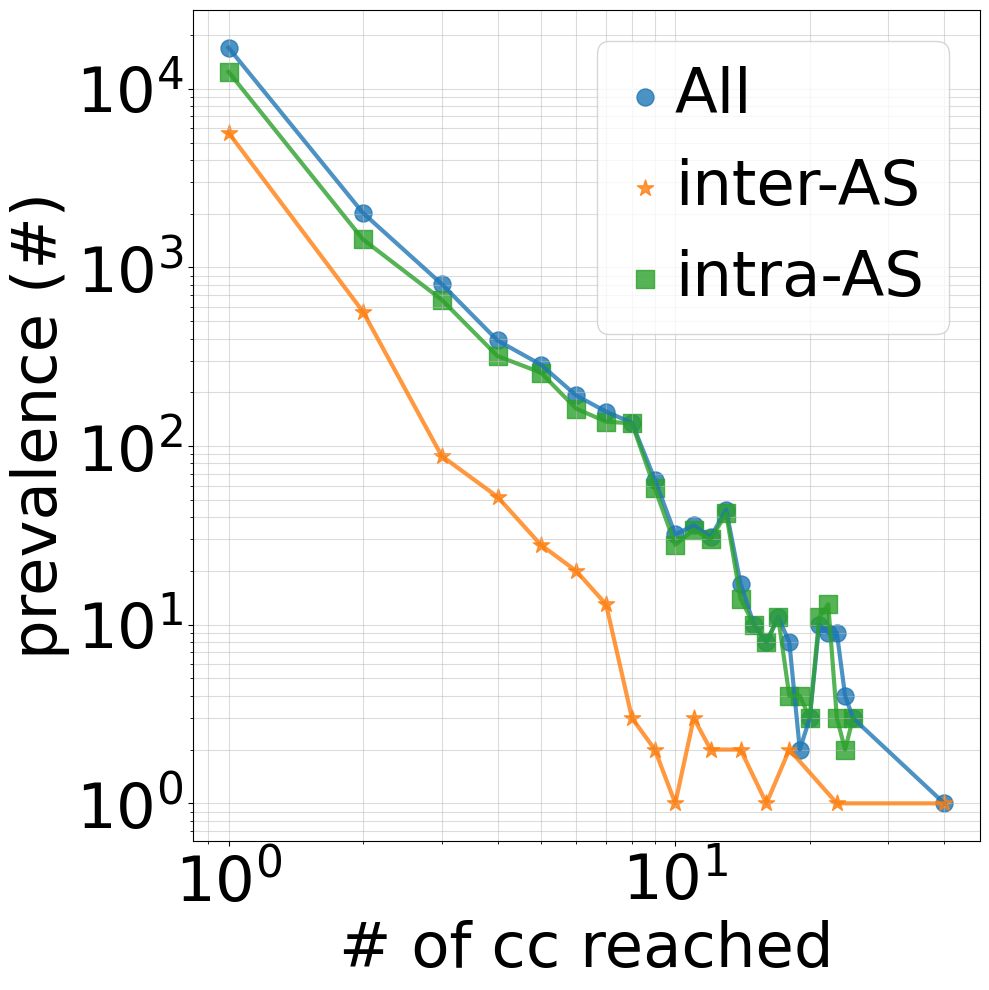

In [17]:
m = itertools.cycle(["o", "*", "s"])

fig, ax = plt.subplots(1, figsize=(10, 10))

ax.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
ax.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')


for label, df in [("All", all_superrouters),
                  ("inter-AS", external_superrouters),
                  ("intra-AS", internal_superrouters), ]:
   
    prevalence = df.groupby("cc_cnt")["router_cc"] \
        .count() \
        .reset_index() \
        .sort_values("cc_cnt")
    prevalence.columns = ["cc_deg", "cnt"]
    

    ax.scatter(
        prevalence["cc_deg"].values, 
        prevalence["cnt"].values, 
        label=f"{label}", 
        s=150,
        alpha=0.8,
        marker=next(m)
    )
    
    ax.plot(
        prevalence["cc_deg"].values, 
        prevalence["cnt"].values, 
        lw=3,
        alpha=0.8,
    )


FONTSIZE = 45
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('prevalence (#)', fontsize=FONTSIZE)
ax.set_xlabel('# of cc reached', fontsize=FONTSIZE)
# ax.set_title('far-side RTT', fontsize=20)
ax.tick_params(labelsize=FONTSIZE)
# ax.set_xlim(0, 5)
fig.subplots_adjust(hspace=0)
fig.tight_layout()

ax.legend(loc='upper right', ncol=1, frameon=True, fontsize=FONTSIZE,
          handletextpad=0.1, columnspacing=0.1, handlelength=0.75)

# fig.savefig("figures/superrouters/cc_router_cdf.pdf")


In [18]:
np.percentile(all_superrouters["cc_cnt"], [90, 95, 98, 99])

array([ 3.,  5.,  8., 10.])

In [19]:
lhl.loc[(lhl["near_node_id"] == 3542)
        & (lhl["near_node_asn"] == lhl["far_node_asn"])
        & (lhl["near_side_cc"] != lhl["far_side_cc"])] \
    .drop_duplicates(["near_side_cc", "far_side_cc"]) \
    .head()

,near_side_addr,far_side_addr,mpls_tunnel,near_side_rdns,far_side_rdns,near_side_rtt,far_side_rtt,near_side_timestamp,far_side_timestamp,near_node_id,far_node_id,near_node_asn,far_node_asn,near_side_cc,far_side_cc,near_side_lat,near_side_lon,far_side_lat,far_side_lon,diff_rtt


# Chicago router

/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/lhledge-0.1.0-py3.10.egg/lhledge/superrouters.py:89: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
/home/esteban/projects/lhl-edge/.lhl-edge/lib/python3.10/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


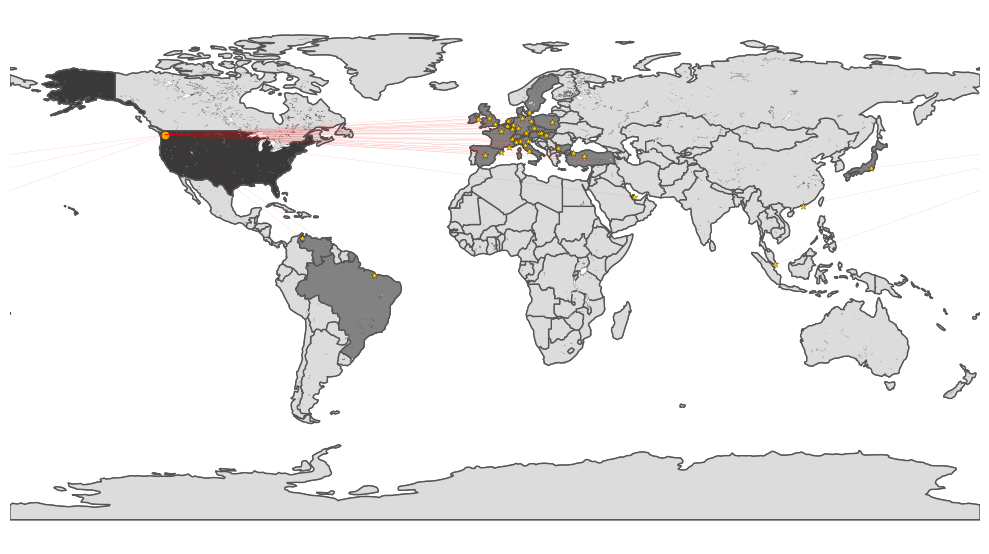

In [20]:
superrouters.plot_superrouters_map(3313, filtered_geoloc_hops, all_superrouters, lhl, 
                                   filename="")

In [21]:
all_superrouters.loc[all_superrouters["router_id"] == 3313]

,router_id,router_cc,asn,cc_cnt,cc_list
190,3313,US,3257,25,"[AT, CH, BR, NL, BE, BG, GB, FR, SG, IE, QA, I..."
